In [15]:
# =========================
#  Environment Setup
# =========================
!pip install --upgrade pip \
&& pip config set global.extra-index-url https://pip.repos.neuron.amazonaws.com \
&& pip install --upgrade optimum[neuronx] \
&& pip install --upgrade optimum-neuron neuronx-cc transformers_neuronx neuronx_distributed neuronx-cc==2.* neuronx-distributed-inference transformers torch-neuronx accelerate diffusers triton protobuf \
&& pip install faiss-cpu numpy scikit-learn pandas matplotlib seaborn
print("✅ Environment setup complete!")

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Writing to /root/.config/pip/pip.conf
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached optimum_neuron-0.1.0-py3-none-any.whl.metadata (15 kB)
  Using cached transformers-4.41.2-py3-none-any.whl.metadata (43 kB)
INFO: pip is looking at multiple versions of optimum-neuron to determine which version is compatible with other requirements. This could take a while.
  Using cached optimum_neuron-0.0.28-py3-none-any.whl.metadata (15 kB)
  Using cached optimum_neuron-0.0.27-py3-none-any.whl.metadata (15 kB)
  Using cached optimum_neuron-0.0.26-py3-none-any.whl.metadata (15 kB)
  Using cached optimum_neuron-0.0.25-py3-none-any.whl.metadata (15 kB)
  Using cached optimum_neuron-0.0.24-py3-none-any.whl.metadata (15 kB)
  Using cached transformers-4.41.1-py3-none-any.whl.metadata (43 kB)
  Using cached accelerate-0.29.2-py3-none-any.whl.metadata (18 kB)
  Using cache

In [ ]:
# add discussion point about batch size. if we want more through put we compile with larger batch size and use more neuron cores. Otherwise use batch size=1 

In [16]:
! export BOOKS_DF_DS="books_df.pkl"; export NROWS="3000" \
&& python cell_load_books.py

✅ Books dataset loaded & saved in books_df.pkl.


In [25]:
# If you haven't compiled the model and pushed to huggingface run the following steps
! cat nxd_vllm_8b.yaml \
&& export COMPILED_MODEL_ID="yahavb/nxd_vllm_8B" \
&& git config --global credential.helper store \
&& export HUGGINGFACE_TOKEN=hf_TBD \
&& python cell_compile_vllm.py nxd_vllm_8b.yaml

model: "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
tensor_parallel_size: 8
max_num_seqs: 1
max_model_len: 1024
override_neuron_config: {}
device: "neuron"
WARNING 04-03 15:29:37 _custom_ops.py:18] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
root: MASTER_ADDR environment variable is not set, defaulting to localhost
root: Found libneuronpjrt.so. Setting PJRT_DEVICE=NEURON.
INFO 04-03 15:29:41 config.py:901] Defaulting to use mp for distributed inference
WARNING 04-03 15:29:41 config.py:376] Async output processing is only supported for CUDA or TPU. Disabling it for other platforms.
INFO 04-03 15:29:41 llm_engine.py:226] Initializing an LLM engine (v0.1.dev2831+gc097c18) with config: model='deepseek-ai/DeepSeek-R1-Distill-Llama-8B', speculative_config=None, tokenizer='deepseek-ai/DeepSeek-R1-Distill-Llama-8B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, rope_scaling=None, rope_theta=None, tokenizer_revisi

In [31]:
## expand user interests with LLM - DeepSeek-R1-Distill-Llama-8B deployed with vLLM using NxDI. 
## input - list of books interest `BOOKS_DF_DS`
## output - list of expanded reader interests using LLM instruction 
! export BOOKS_DF_DS_EXP_INTEREST="books_with_expanded_interest_llama8b.pkl" \
&& export BOOKS_DF_DS="books_df.pkl" \
&& export COMPILED_MODEL_ID="yahavb/nxd_vllm_8B" \
&& python cell_expand_interest_llm.py nxd_vllm_8b.yaml

WARNING 04-03 16:10:12 _custom_ops.py:18] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
root: MASTER_ADDR environment variable is not set, defaulting to localhost
root: Found libneuronpjrt.so. Setting PJRT_DEVICE=NEURON.
Fetching 11 files: 100%|██████████████████████| 11/11 [00:00<00:00, 7046.02it/s]
Repository 'yahavb/nxd_vllm_8B' downloaded to 'yahavb/nxd_vllm_8B'.
Loaded the dataset books_df.pkl
INFO 04-03 16:10:16 config.py:901] Defaulting to use mp for distributed inference
WARNING 04-03 16:10:16 config.py:376] Async output processing is only supported for CUDA or TPU. Disabling it for other platforms.
INFO 04-03 16:10:16 llm_engine.py:226] Initializing an LLM engine (v0.1.dev2831+gc097c18) with config: model='deepseek-ai/DeepSeek-R1-Distill-Llama-8B', speculative_config=None, tokenizer='deepseek-ai/DeepSeek-R1-Distill-Llama-8B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, rope_scaling=None, rope_t

In [26]:
import pandas as pd
df = pd.read_pickle('books_with_expanded_interest_llama8b.pkl')
print(df.head(2))

           Id                           Title         User_id  \
0  1882931173  Its Only Art If Its Well Hung!   AVCGYZL8FQQTD   
1  0826414346        Dr. Seuss: American Icon  A30TK6U7DNS82R   

  review/helpfulness  review/score  review/time  \
0                7/7           4.0    940636800   
1              10/10           5.0   1095724800   

                           review/summary  \
0  Nice collection of Julie Strain images   
1                       Really Enjoyed It   

                                         review/text  \
0  This is only for Julie Strain fans. It's a col...   
1  I don't care much for Dr. Seuss but after read...   

                                   expanded_interest  
0  So why four stars and not five? Let me think. ...  
1  NGS, like the original "Oh The Think You Get",...  


In [29]:
# If you haven't compiled the model and pushed to huggingface execute; if it fails, try delete the model root directory - yahavb in this example
! cat nxd_vllm_SD_8B_1B.yaml \
&& git config --global credential.helper store \
&& export COMPILED_MODEL_ID="yahavb/nxd_vllm_SD_8B_1B" \
&& export HUGGINGFACE_TOKEN=hf_TBD \
&& python cell_compile_vllm.py nxd_vllm_SD_8B_1B.yaml

speculative_model: "meta-llama/Llama-3.2-1B"
speculative_draft_tensor_parallel_size: 1
speculative_max_model_len: 1024
num_speculative_tokens: 7
model: "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
tensor_parallel_size: 8
max_num_seqs: 1
max_model_len: 1024
use_v2_block_manager: true
override_neuron_config: {"enable_fused_speculation":true} 
device: "neuron"
WARNING 04-03 15:33:14 _custom_ops.py:18] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
root: MASTER_ADDR environment variable is not set, defaulting to localhost
root: Found libneuronpjrt.so. Setting PJRT_DEVICE=NEURON.
INFO 04-03 15:33:17 config.py:901] Defaulting to use mp for distributed inference
WARNING 04-03 15:33:18 config.py:376] Async output processing is only supported for CUDA or TPU. Disabling it for other platforms.
INFO 04-03 15:33:18 llm_engine.py:226] Initializing an LLM engine (v0.1.dev2831+gc097c18) with config: model='deepseek-ai/DeepSeek-R1-Distill-Llama-8B', speculative_confi

In [32]:
## expand user interests with LLM - DeepSeek-R1-Distill-Llama-8B deployed with vLLM using NxDI. 
## input - list of books interest `BOOKS_DF_DS`
## output - list of expanded reader interests using LLM instruction 
! export BOOKS_DF_DS_EXP_INTEREST="books_with_expanded_interest_llama8bsd1b.pkl" \
&& export BOOKS_DF_DS="books_df.pkl" \
&& export COMPILED_MODEL_ID="yahavb/nxd_vllm_SD_8B_1B" \
&& python cell_expand_interest_llm.py nxd_vllm_SD_8B_1B.yaml

WARNING 04-03 16:19:40 _custom_ops.py:18] Failed to import from vllm._C with ModuleNotFoundError("No module named 'vllm._C'")
root: MASTER_ADDR environment variable is not set, defaulting to localhost
root: Found libneuronpjrt.so. Setting PJRT_DEVICE=NEURON.
Fetching 11 files: 100%|█████████████████████| 11/11 [00:00<00:00, 13144.54it/s]
Repository 'yahavb/nxd_vllm_SD_8B_1B' downloaded to 'yahavb/nxd_vllm_SD_8B_1B'.
Loaded the dataset books_df.pkl
INFO 04-03 16:19:44 config.py:901] Defaulting to use mp for distributed inference
WARNING 04-03 16:19:45 config.py:376] Async output processing is only supported for CUDA or TPU. Disabling it for other platforms.
INFO 04-03 16:19:45 llm_engine.py:226] Initializing an LLM engine (v0.1.dev2831+gc097c18) with config: model='deepseek-ai/DeepSeek-R1-Distill-Llama-8B', speculative_config=SpeculativeConfig(draft_model='meta-llama/Llama-3.2-1B', num_spec_tokens=7), tokenizer='deepseek-ai/DeepSeek-R1-Distill-Llama-8B', skip_tokenizer_init=False, token

In [ ]:
# If you haven't compiled the model and pushed to huggingface execute; if it fails, try delete the model root directory - yahavb in this example
! cat nxd_vllm_SD_8B_1B.yaml \
&& git config --global credential.helper store \
&& export COMPILED_MODEL_ID="yahavb/nxd_vllm_SD_8B_1B" \
&& export HUGGINGFACE_TOKEN=hf_TBD \
&& python cell_compile_vllm.py nxd_vllm_SD_8B_1B.yaml

In [33]:
import pandas as pd
df = pd.read_pickle('books_with_expanded_interest_llama8bsd1b.pkl')
print(df.head(2))

           Id                           Title         User_id  \
0  1882931173  Its Only Art If Its Well Hung!   AVCGYZL8FQQTD   
1  0826414346        Dr. Seuss: American Icon  A30TK6U7DNS82R   

  review/helpfulness  review/score  review/time  \
0                7/7           4.0    940636800   
1              10/10           5.0   1095724800   

                           review/summary  \
0  Nice collection of Julie Strain images   
1                       Really Enjoyed It   

                                         review/text  \
0  This is only for Julie Strain fans. It's a col...   
1  I don't care much for Dr. Seuss but after read...   

                                   expanded_interest  
0  It's a good supplement to her other books.\n\n...  
1  Okay, so I need to expand the given book inter...  


In [68]:
# If you haven't compiled the encoder model, t5, and pushed to huggingface run the following steps
! export COMPILED_MODEL_ID="yahavb/t5-v1_1-base" \
&& export MODEL_ID="google/t5-v1_1-base" \
&& export MAX_SEQ_LEN=1024 \
&& git config --global credential.helper store \
&& export HUGGINGFACE_TOKEN=hf_TBD \
&& python cell_compile_t5_1.py

/opt/conda/lib/python3.10/site-packages/neuronx_distributed/modules/moe/expert_mlps.py:11: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from neuronx_distributed.modules.moe.blockwise import (
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/opt/conda/lib/python3.10/site-packages/neuronx_distributed/modules/moe/expert_mlps.py:11: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from neuronx_distributed.modules.moe.blockwise import (
[2025-04-03 20:24:55.883: I neuronx_distributed/parallel_layers/parallel_state.py:51

In [66]:
## generate T5-based embeddings and FAISS index from the expanded lists, DeepSeek-R1-Distill-Llama-8B and meta-llama/Llama-3.2-1B as draft model, 
## The T5-based embeddings are being converted to FAISS (Facebook AI Similarity Search) index. It is a vector search engine that allows 
## fast nearest-neighbor retrieval. It stores T5-based embeddings computed from expanded interests. Each book review is transformed into a vector.
## Used to find books closest in meaning to a user's expanded interest.
## input - books_df_dataset_expanded_interest
## output - the top K most similar books.
! unset BOOKS_DF_DS_EXP_INTEREST; unset BOOKS_DF_FAISS_IDX \
&& export BOOKS_DF_DS_EXP_INTEREST="books_with_expanded_interest_llama8b.pkl" \
&& export BOOKS_DF_FAISS_IDX="books_with_expanded_interest_llama8b_t5_faiss.index" \
&& export MODEL_ID="google/t5-v1_1-base" \
&& export COMPILED_MODEL_ID="yahavb/t5-v1_1-base" \
&& export MAX_SEQ_LEN=1024 \
&& python cell_t5_embeddings.py

/opt/conda/lib/python3.10/site-packages/neuronx_distributed/modules/moe/expert_mlps.py:11: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from neuronx_distributed.modules.moe.blockwise import (
Loaded dataset path: books_with_expanded_interest_llama8b.pkl
Fetching 1 files: 100%|████████████████████████| 1/1 [00:00<00:00, 26546.23it/s]
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
✅ Updated .pkl with 't5_embedding' column: books_with_expanded_interest_llama8b.pkl
✅ T5 Embeddings & FAISS index saved in books_with_expanded_interest_llama8b_t5_faiss

In [65]:
! unset BOOKS_DF_DS_EXP_INTEREST; unset BOOKS_DF_FAISS_IDX \
&& export BOOKS_DF_DS_EXP_INTEREST="books_with_expanded_interest_llama8bsd1b.pkl" \
&& export BOOKS_DF_FAISS_IDX="books_with_expanded_interest_llama8bsd1b_t5_faiss.index" \
&& export MODEL_ID="google/t5-v1_1-base" \
&& export COMPILED_MODEL_ID="yahavb/t5-v1_1-base" \
&& export MAX_SEQ_LEN=1024 \
&& python cell_t5_embeddings.py

/opt/conda/lib/python3.10/site-packages/neuronx_distributed/modules/moe/expert_mlps.py:11: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from neuronx_distributed.modules.moe.blockwise import (
Loaded dataset path: books_with_expanded_interest_llama8bsd1b.pkl
Fetching 1 files: 100%|████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
✅ Updated .pkl with 't5_embedding' column: books_with_expanded_interest_llama8bsd1b.pkl
✅ T5 Embeddings & FAISS index saved in books_with_expanded_interest_llama8bs

In [69]:
! unset BOOKS_DF_DS_EXP_INTEREST; unset BOOKS_DF_FAISS_IDX \
&& export BOOKS_DF_DS_EXP_INTEREST="books_with_expanded_interest_llama8b.pkl" \
&& export BOOKS_DF_FAISS_IDX="books_with_expanded_interest_llama8b_st_faiss.index" \
&& python cell_st_embeddings.py

Loaded dataset path: books_with_expanded_interest_llama8b.pkl
✅ Updated .pkl with 'st_embedding' column: books_with_expanded_interest_llama8b.pkl
✅ SentenceTransformer embeddings computed and saved in books_with_expanded_interest_llama8b_st_faiss.index
✅ First 5 stored vectors (embeddings):
[[ 0.05363178 -0.04214235  0.03135043 ... -0.04966624 -0.00177271
   0.05110864]
 [-0.1558048   0.02705598  0.01126792 ...  0.06719594  0.0402836
   0.01248577]
 [-0.10727395  0.03937738 -0.01662963 ...  0.05637052 -0.03619089
   0.01270515]
 [ 0.0012678   0.06796172  0.03678236 ... -0.04052351 -0.01039069
   0.03031137]
 [ 0.01451087 -0.00123152  0.02187269 ... -0.00772454 -0.07840051
   0.06921192]]


In [70]:
! unset BOOKS_DF_DS_EXP_INTEREST; unset BOOKS_DF_FAISS_IDX \
&& export BOOKS_DF_DS_EXP_INTEREST="books_with_expanded_interest_llama8bsd1b.pkl" \
&& export BOOKS_DF_FAISS_IDX="books_with_expanded_interest_llama8bsd1b_st_faiss.index" \
&& python cell_st_embeddings.py

Loaded dataset path: books_with_expanded_interest_llama8bsd1b.pkl
✅ Updated .pkl with 'st_embedding' column: books_with_expanded_interest_llama8bsd1b.pkl
✅ SentenceTransformer embeddings computed and saved in books_with_expanded_interest_llama8bsd1b_st_faiss.index
✅ First 5 stored vectors (embeddings):
[[-0.07715432 -0.05330997 -0.01795058 ... -0.02912272  0.07026347
   0.00638051]
 [ 0.02143679  0.00809719 -0.00651785 ... -0.01991016 -0.08260988
   0.08638958]
 [-0.06823471 -0.01901459 -0.01859644 ...  0.06281149 -0.01971497
  -0.01966992]
 [-0.02237975  0.08178423 -0.02036448 ...  0.03792991 -0.02325772
  -0.02850528]
 [ 0.01451087 -0.00123152  0.02187269 ... -0.00772454 -0.07840051
   0.06921192]]


In [71]:
# =========================
# Cell: multi-LLM Book Recommendation
# =========================

import pandas as pd
import numpy as np
import faiss
import re

def recommend_books_multi_llm(user_reviews,llm_name,top_k=5):
    """
    Recommend books based on expansions from multiple LLM sizes (e.g. 8B or 8B SD 1B).
    
    1) Loads the pickled DataFrame: books_with_expanded_interest_{llm_name}.pkl
       which must contain columns:
         - 'review/text'
         - 'expanded_interest'
         - 't5_embedding'
         - 'st_embedding'
    2) Loads FAISS indices:
       books_with_expanded_interest_{llm_name}_t5_faiss.index
       books_with_expanded_interest_{llm_name}_st_faiss.index
    3) Finds the row(s) matching user_reviews (partial match).
    4) Retrieves that row’s embeddings: "t5_embedding", "st_embedding".
    5) Searches in FAISS for top_k neighbors for each embedding approach.
    6) Returns (expanded_interest, recommended_books_ST, recommended_books_T5).

    Example usage:
      recommended_st, recommended_t5 = recommend_books_multi_llm(
          user_reviews=\"I love epic sci-fi novels with deep world-building.\",
          llm_name=\"dsr1llama70b\",
          top_k=5
      )
    """

    # 1) Load expansions & embeddings
    df_file = f"books_with_expanded_interest_{llm_name}.pkl"
    faiss_t5_file = f"books_with_expanded_interest_{llm_name}_t5_faiss.index"
    faiss_st_file = f"books_with_expanded_interest_{llm_name}_st_faiss.index"

    books_df = pd.read_pickle(df_file)
    index_t5 = faiss.read_index(faiss_t5_file)
    index_st = faiss.read_index(faiss_st_file)

    # 2) Match the user review by partial or exact match
    matched_rows = books_df[books_df["review/text"].str.contains(re.escape(user_reviews), case=False, na=False)]
    if matched_rows.empty:
        print("⚠️ No exact or partial match found for user review. Using default interest.")
        # fallback approach: pick the first row or do a random choice
        row_index = 0
    else:
        row_index = matched_rows.index[0]

    expanded_interest = books_df.loc[row_index, "expanded_interest"]
    print(f"\n🔹 LLM = {llm_name}")
    print(f"🔹 Expanded Interest: {expanded_interest}")

    # 3) Retrieve that row's T5 & ST embeddings
    #    Must ensure your .pkl includes these columns as lists/floats
    row_t5_emb = np.array(books_df.loc[row_index, "t5_embedding"], dtype="float32").reshape(1, -1)
    row_st_emb = np.array(books_df.loc[row_index, "st_embedding"], dtype="float32").reshape(1, -1)

    # 4) FAISS search
    distances_t5, indices_t5 = index_t5.search(row_t5_emb, top_k)
    distances_st, indices_st = index_st.search(row_st_emb, top_k)

    # 5) Retrieve recommended books
    recommended_t5 = books_df.iloc[indices_t5[0]][["Title", "review/summary"]].copy()
    recommended_st = books_df.iloc[indices_st[0]][["Title", "review/summary"]].copy()

    return expanded_interest, recommended_st, recommended_t5


# =========================
# TEST EXAMPLE
# =========================
user_reviews = "I love epic sci-fi novels with deep world-building."

for llm_variant in ["llama8b", "llama8bsd1b"]:
    expanded_interest, rec_st, rec_t5 = recommend_books_multi_llm(user_reviews, llm_name=llm_variant)
    print(f"\n🔹 LLM: {llm_variant} - ST Recommendations:")
    print(rec_st)
    print(f"\n🔹 LLM: {llm_variant} - T5 Recommendations:")
    print(rec_t5)


⚠️ No exact or partial match found for user review. Using default interest.

🔹 LLM = llama8b
🔹 Expanded Interest: So why four stars and not five? Let me think. The problem is the

🔹 LLM: llama8b - ST Recommendations:
                                                  Title  \
0                        Its Only Art If Its Well Hung!   
246   King James: Believe the Hype---The LeBron Jame...   
2373                       The Scarlet Letter A Romance   
477                  Night World: Daughters Of Darkness   
2708                                    Larks: A memoir   

                                     review/summary  
0            Nice collection of Julie Strain images  
246                                  Great Product!  
2373  A Great Book with a capital G and a capital B  
477                        READ IT READ IT READ IT!  
2708                   Silver Wedding, Maeve Binchy  

🔹 LLM: llama8b - T5 Recommendations:
                               Title  \
0     Its Only Art If Its 

No exact or partial match found for user review. Using default interest.

🔹 LLM = llama8b
🔹 Expanded Interest: So why four stars and not five? Let me think. The problem is the
No exact or partial match found for user review. Using default interest.

🔹 LLM = llama8bsd1b
🔹 Expanded Interest: It's a good supplement to her other books.

Okay, so I need to


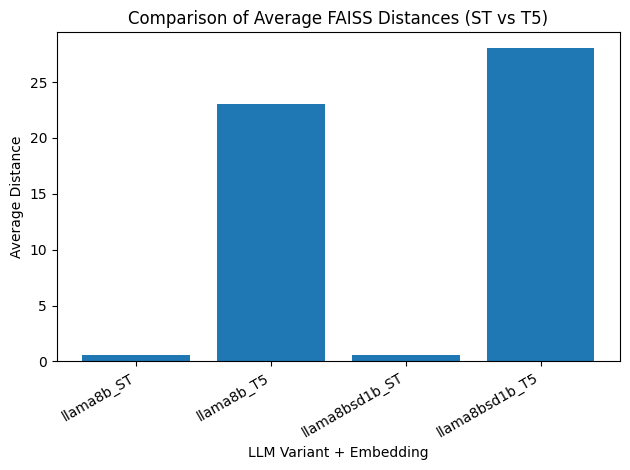

'\nX-axis: Each approach is labeled by (LLM variant)_(embedding), for instance dsr1llama8b_ST, dsr1llama8b_T5, etc.\nY-axis: The average distance over the top-K retrieved items. Lower distance indicates closer (i.e., more relevant) matches. \n'

In [75]:
import pandas as pd
import numpy as np
import faiss
import re
import matplotlib.pyplot as plt

def recommend_books_multi_llm_with_distances(user_reviews,llm_name,top_k=5):
    """
    Similar to 'recommend_books_multi_llm' but also returns the raw FAISS distances
    (for ST and T5) so we can compare them across approaches.
    """
    # 1) Load expansions & embeddings
    df_file = f"books_with_expanded_interest_{llm_name}.pkl"
    faiss_t5_file = f"books_with_expanded_interest_{llm_name}_t5_faiss.index"
    faiss_st_file = f"books_with_expanded_interest_{llm_name}_st_faiss.index"

    books_df = pd.read_pickle(df_file)
    index_t5 = faiss.read_index(faiss_t5_file)
    index_st = faiss.read_index(faiss_st_file)

    # 2) Match user review by partial or exact match
    matched_rows = books_df[books_df["review/text"].str.contains(
        re.escape(user_reviews), case=False, na=False
    )]

    if matched_rows.empty:
        print("No exact or partial match found for user review. Using default interest.")
        row_index = 0  # fallback, pick the first or random row
    else:
        row_index = matched_rows.index[0]

    expanded_interest = books_df.loc[row_index, "expanded_interest"]
    print(f"\n🔹 LLM = {llm_name}")
    print(f"🔹 Expanded Interest: {expanded_interest}")

    # 3) Retrieve T5 & ST embeddings
    row_t5_emb = np.array(
        books_df.loc[row_index, "t5_embedding"], dtype="float32"
    ).reshape(1, -1)
    row_st_emb = np.array(
        books_df.loc[row_index, "st_embedding"], dtype="float32"
    ).reshape(1, -1)

    # 4) FAISS search
    distances_t5, indices_t5 = index_t5.search(row_t5_emb, top_k)
    distances_st, indices_st = index_st.search(row_st_emb, top_k)

    # 5) Retrieve recommended books
    recommended_t5 = books_df.iloc[indices_t5[0]][["Title", "review/summary"]].copy()
    recommended_st = books_df.iloc[indices_st[0]][["Title", "review/summary"]].copy()

    # Return the recommended books plus the raw distances
    return (
        expanded_interest,          # str
        recommended_st,            # DataFrame
        recommended_t5,            # DataFrame
        distances_st[0],           # ndarray of shape (top_k,)
        distances_t5[0],           # ndarray of shape (top_k,)
    )


# ============ Compare ST vs T5 Distances Across LLM Variants ============
llm_variants = ["llama8b", "llama8bsd1b"]  
user_review = "I love epic sci-fi novels with deep world-building."
top_k = 5

all_avg_distances = []
labels = []

for llm_variant in llm_variants:
    (
        expanded_interest,
        recommended_st,
        recommended_t5,
        dist_st_array,
        dist_t5_array
    ) = recommend_books_multi_llm_with_distances(user_review, llm_variant, top_k=top_k)

    # Compute the average FAISS distance for ST and T5
    avg_dist_st = dist_st_array.mean()
    avg_dist_t5 = dist_t5_array.mean()

    # Store the results
    all_avg_distances.append(avg_dist_st)
    all_avg_distances.append(avg_dist_t5)

    # Create labels for the bar chart
    labels.append(f"{llm_variant}_ST")
    labels.append(f"{llm_variant}_T5")

# ===== Bar Chart of Average Distances =====
x = np.arange(len(all_avg_distances))  # indices for bars
plt.bar(x, all_avg_distances)
plt.xticks(x, labels, rotation=30, ha="right")
plt.title("Comparison of Average FAISS Distances (ST vs T5)")
plt.xlabel("LLM Variant + Embedding")
plt.ylabel("Average Distance")
plt.tight_layout()
plt.show()

'''
X-axis: Each approach is labeled by (LLM variant)_(embedding), for instance dsr1llama8b_ST, dsr1llama8b_T5, etc.
Y-axis: The average distance over the top-K retrieved items. Lower distance indicates closer (i.e., more relevant) matches. 
'''


⚠️ No exact or partial match found for user review. Using default interest.

🔹 LLM = llama8b
🔹 Expanded Interest: So why four stars and not five? Let me think. The problem is the

========== llama8b: ST vs T5 ==========
Overlap Count: 1
Overlap %: 20.0%
Common Titles: {'Its Only Art If Its Well Hung!'}
⚠️ No exact or partial match found for user review. Using default interest.

🔹 LLM = llama8bsd1b
🔹 Expanded Interest: It's a good supplement to her other books.

Okay, so I need to

========== llama8bsd1b: ST vs T5 ==========
Overlap Count: 1
Overlap %: 33.3%
Common Titles: {'Its Only Art If Its Well Hung!'}
⚠️ No exact or partial match found for user review. Using default interest.

🔹 LLM = llama8b
🔹 Expanded Interest: So why four stars and not five? Let me think. The problem is the
⚠️ No exact or partial match found for user review. Using default interest.

🔹 LLM = llama8bsd1b
🔹 Expanded Interest: It's a good supplement to her other books.

Okay, so I need to

========== ST: 8B vs 8BSD

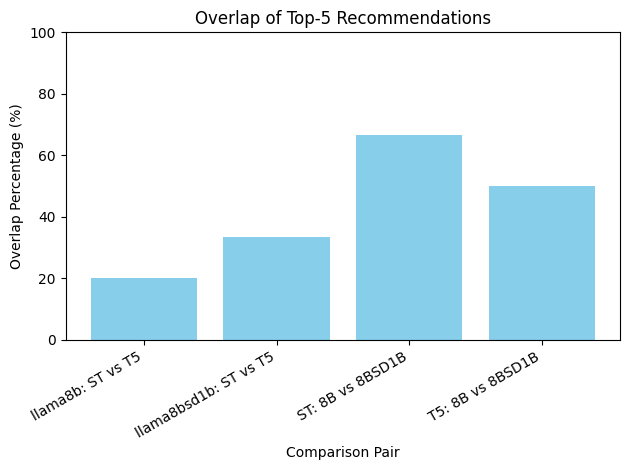

'\neach bar shows how many of the top-5 recommendations the two approaches had in common\ne.g., 40% means 2 out of 5 recommendations overlapped. Higher overlap means the two approaches \nshare more of the same recommendations, so they behave more similarly for that query.\n'

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_recommendation_overlap(set_a, set_b):
    """
    Given two sets of titles (or IDs), compute the overlap
    (intersection) and return both absolute count and percentage.
    """
    overlap = set_a.intersection(set_b)
    overlap_count = len(overlap)
    # Assuming we want overlap relative to top_k from one approach,
    # or the union's size, etc. By default let's measure relative
    # to the smaller set size or simply top_k:
    base_size = min(len(set_a), len(set_b))
    overlap_percent = (overlap_count / base_size) * 100 if base_size > 0 else 0
    return overlap_count, overlap_percent, overlap

# Example usage parameters
llm_variants = ["llama8b", "llama8bsd1b"]
user_review = "I love epic sci-fi novels with deep world-building."
top_k = 5

overlap_values = []
labels = []

# We'll compare:
#  - ST vs T5 for the same LLM variant
#  - (Optional) ST(8B) vs ST(70B), T5(8B) vs T5(70B), etc. (You can expand as needed.)

for llm_variant in llm_variants:
    # Get the recommendations
    expanded_interest, rec_st, rec_t5 = recommend_books_multi_llm(
        user_review, llm_variant, top_k=top_k
    )
    
    # Convert recommended DataFrame columns ("Title") to sets
    st_titles = set(rec_st["Title"].to_list())
    t5_titles = set(rec_t5["Title"].to_list())
    
    # Compute overlap between ST and T5 for this same LLM variant
    overlap_count, overlap_percent, overlap_titles = compute_recommendation_overlap(
        st_titles, t5_titles
    )
    
    label = f"{llm_variant}: ST vs T5"
    labels.append(label)
    overlap_values.append(overlap_percent)
    
    print(f"\n========== {label} ==========")
    print(f"Overlap Count: {overlap_count}")
    print(f"Overlap %: {overlap_percent:.1f}%")
    print(f"Common Titles: {overlap_titles}")


recommendation_sets = {}
for llm_variant in llm_variants:
    _, rec_st, rec_t5 = recommend_books_multi_llm(user_review, llm_variant, top_k=top_k)
    recommendation_sets[(llm_variant, "ST")] = set(rec_st["Title"].to_list())
    recommendation_sets[(llm_variant, "T5")] = set(rec_t5["Title"].to_list())

# compare dsr1llama8b_ST vs dsr1llama70b_ST
overlap_count, overlap_percent, overlap_titles = compute_recommendation_overlap(
    recommendation_sets[("llama8b", "ST")],
    recommendation_sets[("llama8bsd1b", "ST")]
)
label = "ST: 8B vs 8BSD1B"
labels.append(label)
overlap_values.append(overlap_percent)

print(f"\n========== {label} ==========")
print(f"Overlap Count: {overlap_count}")
print(f"Overlap %: {overlap_percent:.1f}%")
print(f"Common Titles: {overlap_titles}")

# compare dsr1llama8b_T5 vs dsr1llama70b_T5
overlap_count, overlap_percent, overlap_titles = compute_recommendation_overlap(
    recommendation_sets[("llama8b", "T5")],
    recommendation_sets[("llama8bsd1b", "T5")]
)
label = "T5: 8B vs 8BSD1B"
labels.append(label)
overlap_values.append(overlap_percent)

print(f"\n========== {label} ==========")
print(f"Overlap Count: {overlap_count}")
print(f"Overlap %: {overlap_percent:.1f}%")
print(f"Common Titles: {overlap_titles}")

# ============ Plot  ============
x = np.arange(len(labels))
plt.bar(x, overlap_values, color="skyblue")
plt.xticks(x, labels, rotation=30, ha="right")
plt.ylim(0, 100)  # Overlap % scale is 0-100
plt.title(f"Overlap of Top-{top_k} Recommendations")
plt.xlabel("Comparison Pair")
plt.ylabel("Overlap Percentage (%)")
plt.tight_layout()
plt.show()
'''
each bar shows how many of the top-5 recommendations the two approaches had in common
e.g., 40% means 2 out of 5 recommendations overlapped. Higher overlap means the two approaches 
share more of the same recommendations, so they behave more similarly for that query.
'''

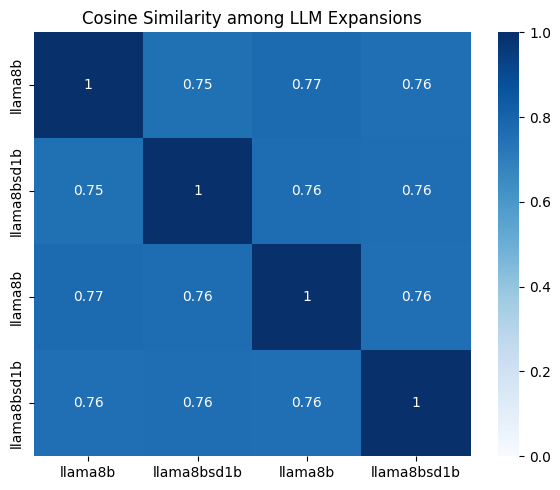

'\nCosine similarity here is measuring how similar the LLM expansions are to each other in terms of embedding space. \nA value of ~0.75 means the text from one expansion is fairly semantically close (75% similarity), while 1.0 means identical or nearly so.\n'

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example embedding function (stub). Replace with your real function:
# e.g., a Sentence Transformer or T5 embedder that takes text -> vector
def embed_text_st(text: str) -> np.ndarray:
    """
    Dummy function for demonstration.
    In reality, you'd load a model like:
      from sentence_transformers import SentenceTransformer
      model = SentenceTransformer('all-MiniLM-L6-v2')
      embedding = model.encode([text])
    and return the embedding (a 1D np.array).
    """
    # Fake random embedding dimension 384 for demonstration
    return np.random.rand(384)

def cosine_similarity(vec_a, vec_b):
    return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

def plot_expansion_similarities(user_query, expansions_df):
    """
    expansions_df should have rows like:
      llm_name, review/text, expanded_interest

    We will:
    1) Filter expansions_df to only rows matching user_query
    2) Embed the 'expanded_interest' for each row
    3) Compute pairwise cosine similarity
    4) Plot a heatmap
    """

    # 1) Filter to expansions for the given user query
    #    (Here we do a contains match; adapt to your actual usage)
    matched_rows = expansions_df[
        expansions_df["review/text"].str.contains(user_query, case=False, na=False)
    ]

    if matched_rows.empty:
        print("No expansions found for this user query.")
        return

    expansions = matched_rows["expanded_interest"].tolist()
    llm_names = matched_rows["llm_name"].tolist()

    # 2) Embed each expansion
    embeddings = []
    for exp in expansions:
        emb = embed_text_st(exp)  # or your real embedding function
        embeddings.append(emb)

    embeddings = np.array(embeddings)  # shape: (N, embedding_dim)

    # 3) Compute pairwise cosine similarity
    n = len(embeddings)
    sim_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            sim_matrix[i, j] = cosine_similarity(embeddings[i], embeddings[j])

    # 4) Plot a heatmap using Seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        sim_matrix,
        xticklabels=llm_names,
        yticklabels=llm_names,
        annot=True,
        cmap="Blues",
        vmin=0.0,
        vmax=1.0
    )
    plt.title("Cosine Similarity among LLM Expansions")
    plt.tight_layout()
    plt.show()

# Suppose expansions_df has columns: ["llm_name", "review/text", "expanded_interest"]
# For each row, "expanded_interest" is the text produced by the LLM describing user interest.
# e.g. expansions_df might have multiple LLM sizes (8B, 70B) for the same "review/text".

# Let's create a small mock DataFrame for demonstration:
data = {
    "llm_name": ["llama8b", "llama8bsd1b","llama8b", "llama8bsd1b"],
    "review/text": [
        "I love epic sci-fi novels with deep world-building.",
        "I love epic sci-fi novels with deep world-building.",
        "I love epic sci-fi novels with deep world-building.",
        "I love epic sci-fi novels with deep world-building."
    ],
    "expanded_interest": [
        "Expansive galactic wars, complex alien societies, multi-world politics.",
        "Huge space operas with intricate planetary systems and philosophical depth.",
        "Interstellar adventures featuring massive cosmic conflicts and layered lore.",
        "Stories that blend technology, grand scale, and nuanced civilization building."
    ]
}
mock_expansions_df = pd.DataFrame(data)

# Now let's plot the similarity among these expansions:
plot_expansion_similarities(
    user_query="I love epic sci-fi novels with deep world-building.",
    expansions_df=mock_expansions_df
)
'''
Cosine similarity here is measuring how similar the LLM expansions are to each other in terms of embedding space. 
A value of ~0.75 means the text from one expansion is fairly semantically close (75% similarity), while 1.0 means identical or nearly so.
'''